<a href="https://colab.research.google.com/github/waytogoasis/app/blob/main/io.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

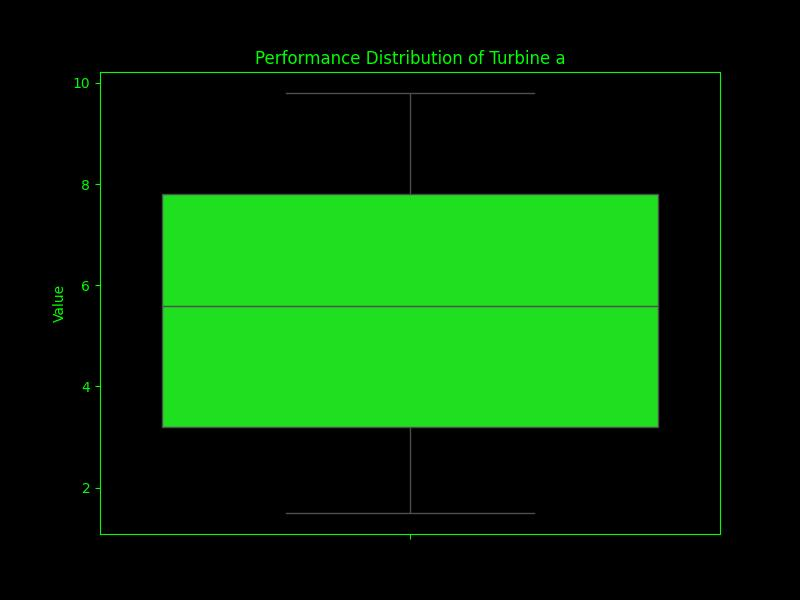

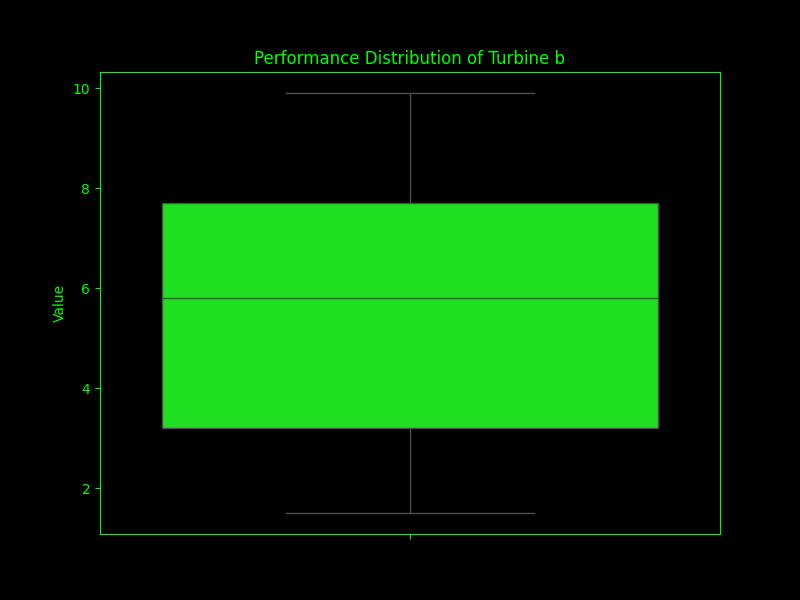

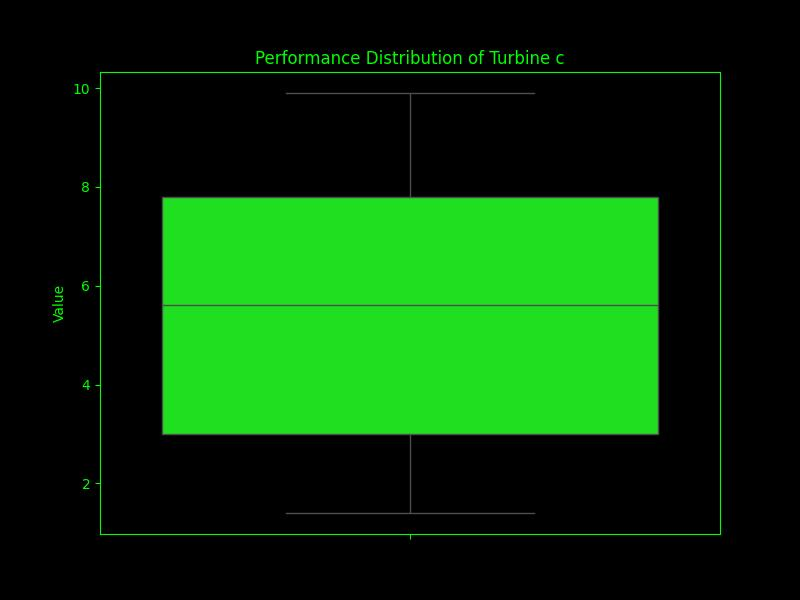

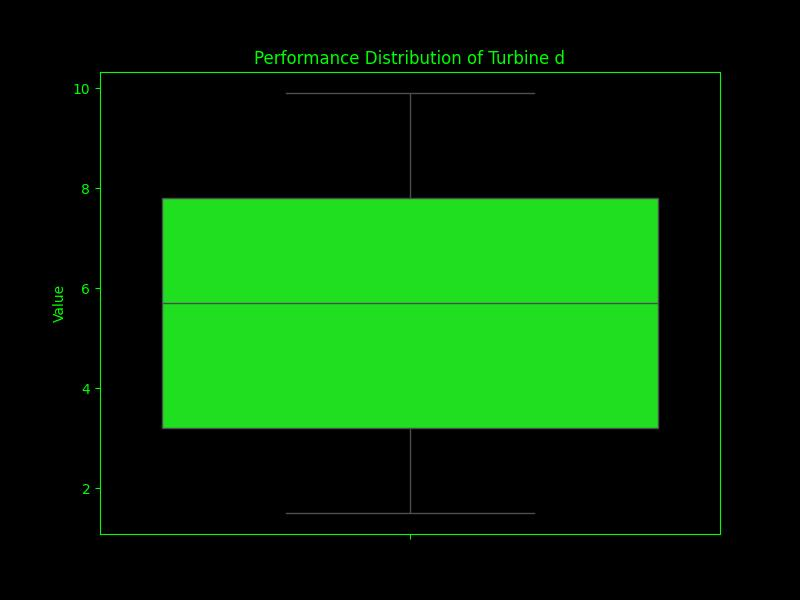

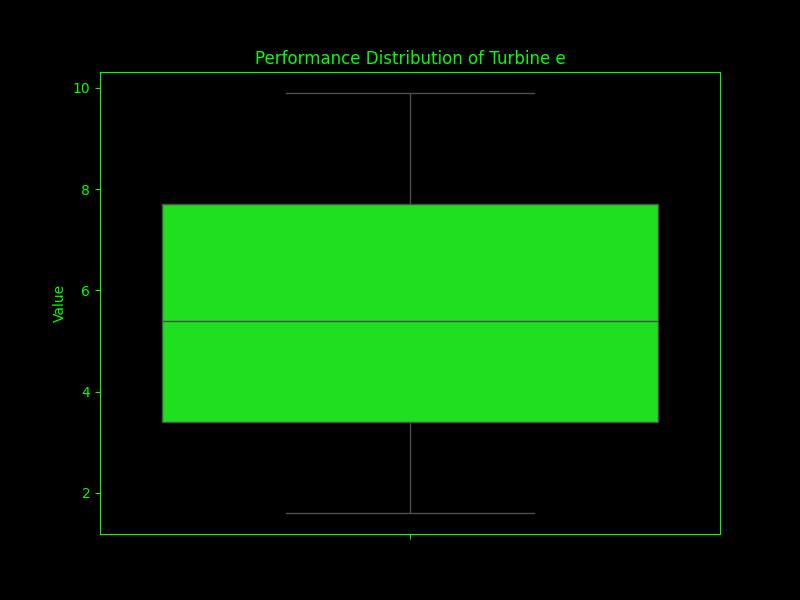

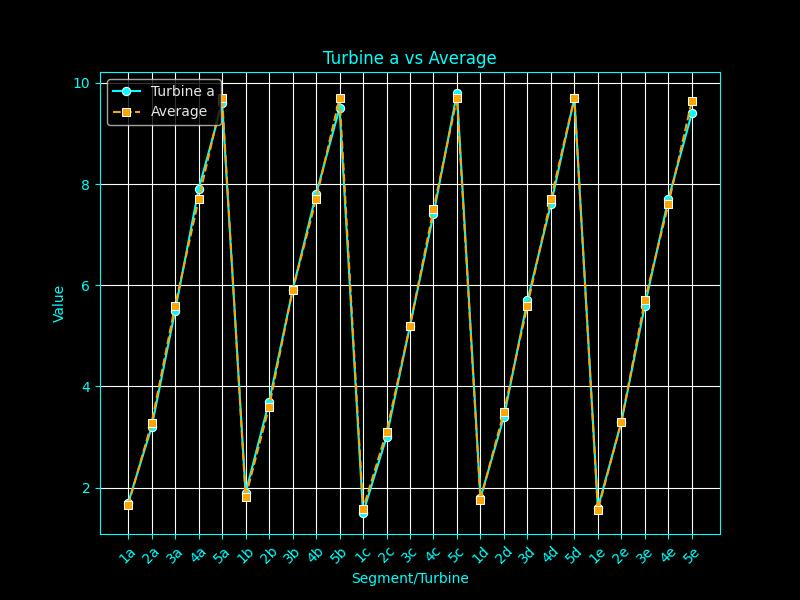

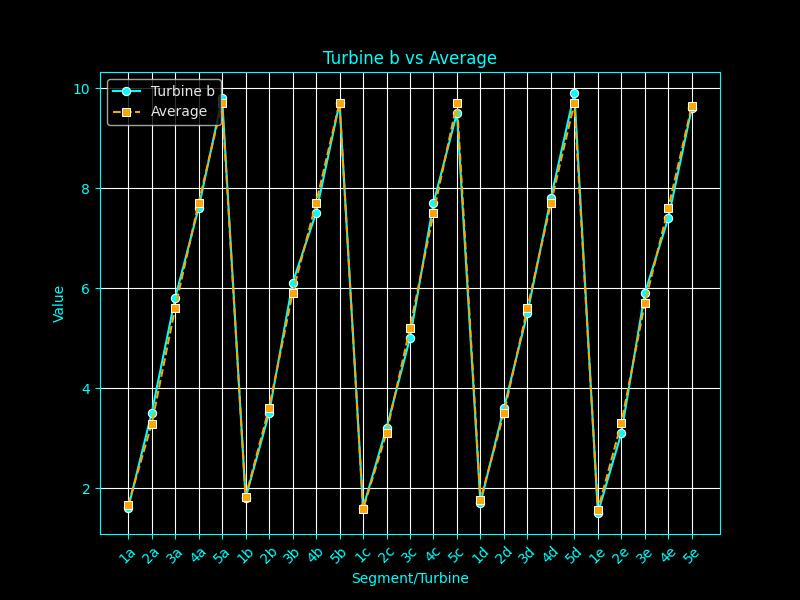

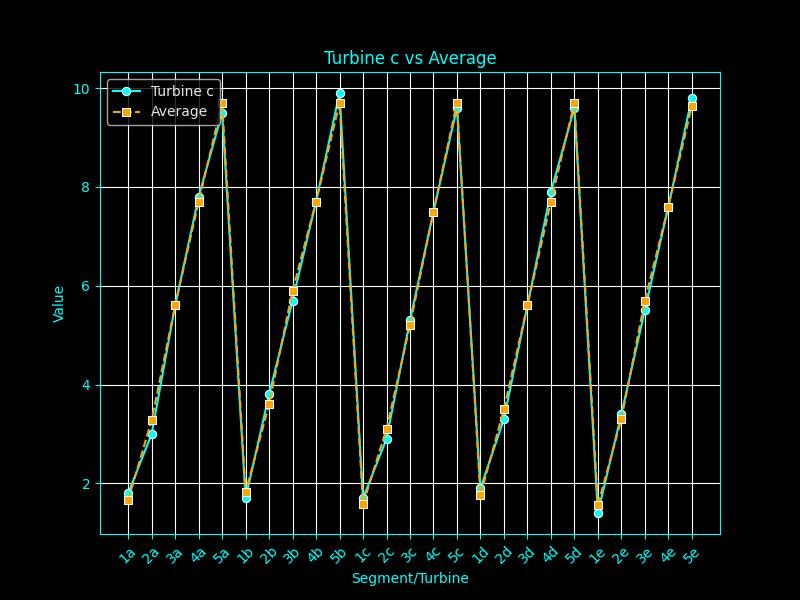

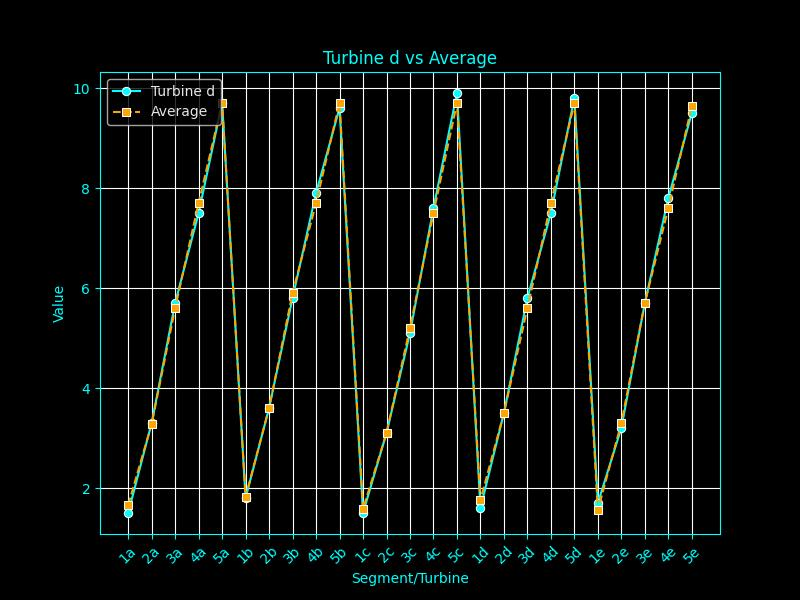

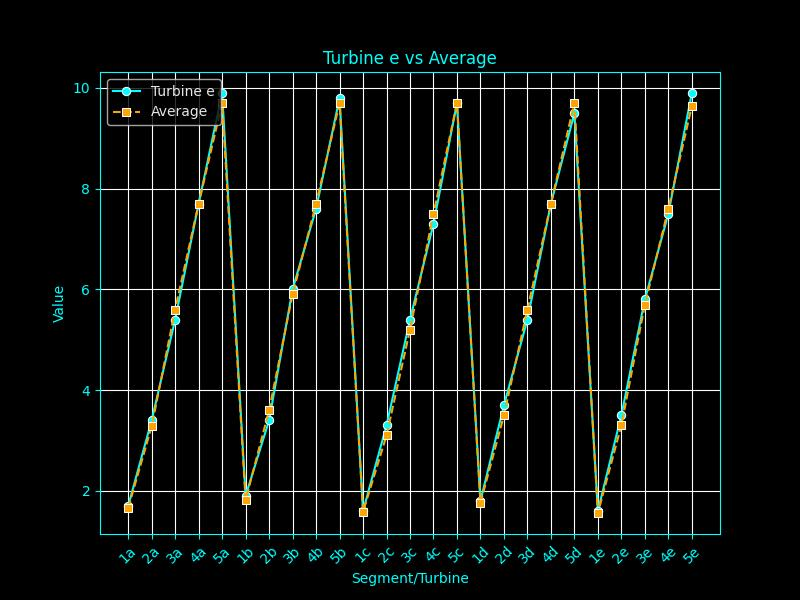

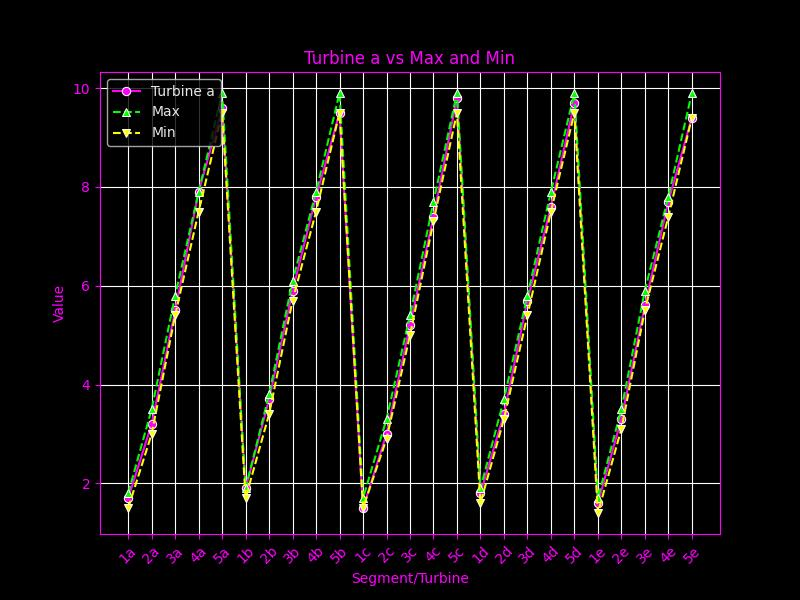

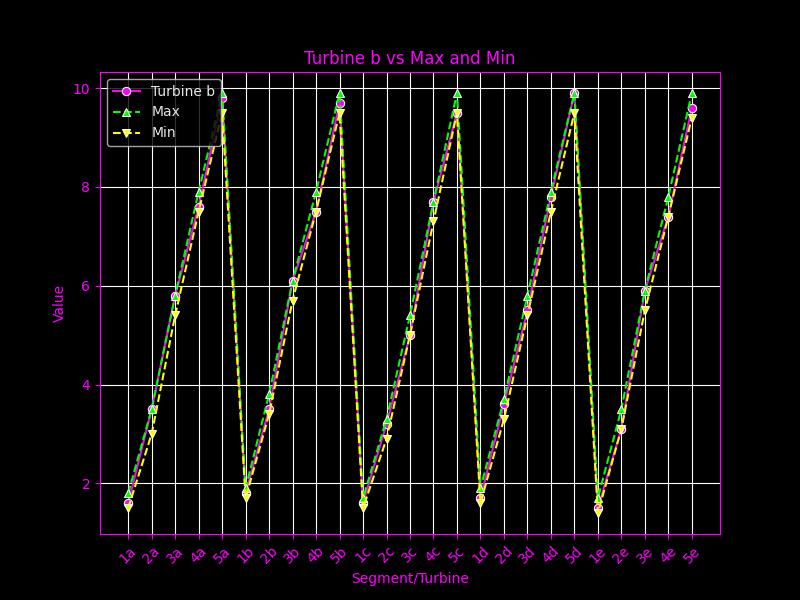

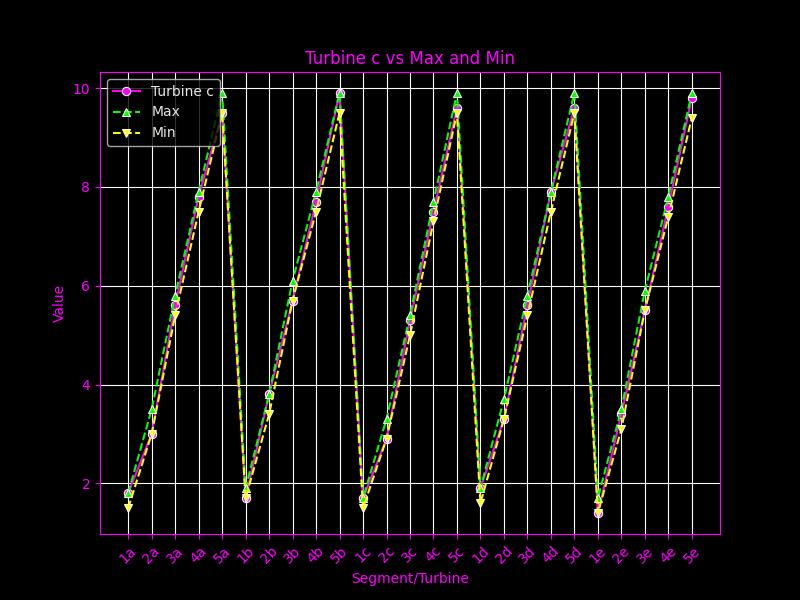

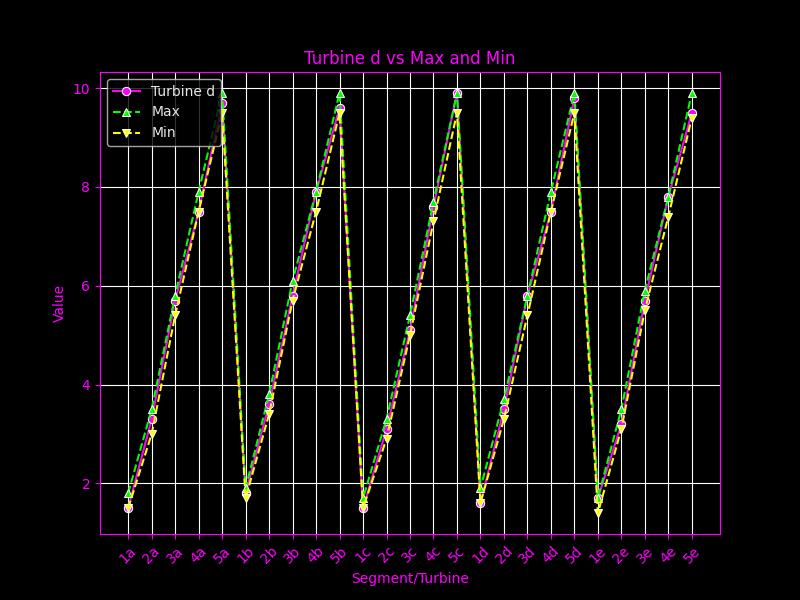

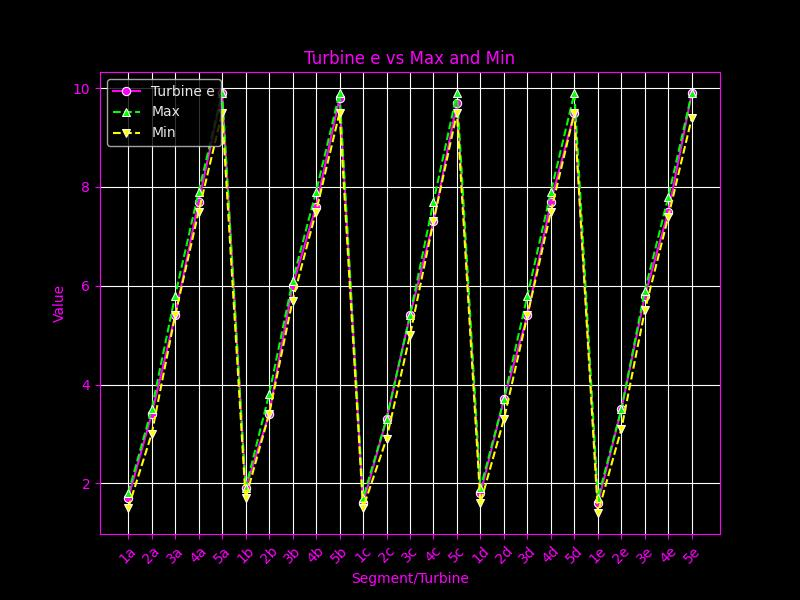

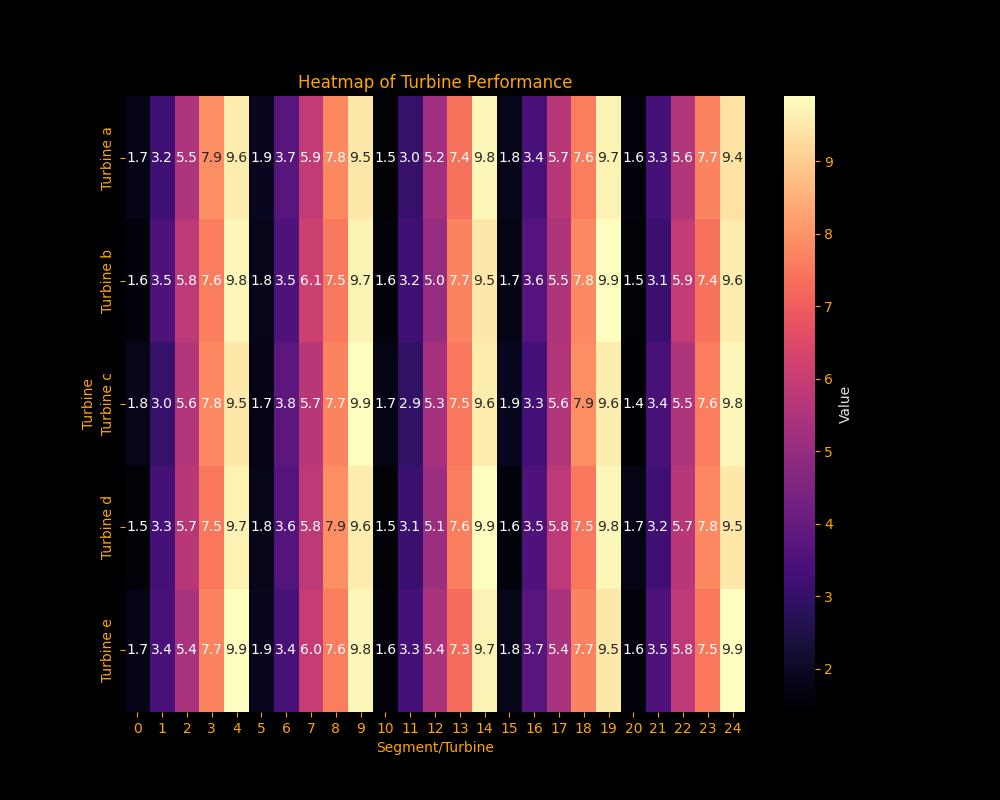

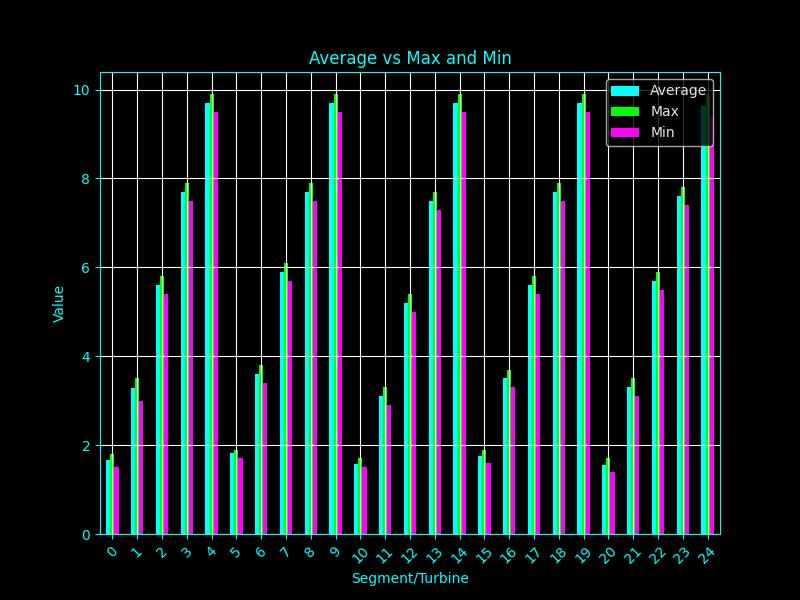

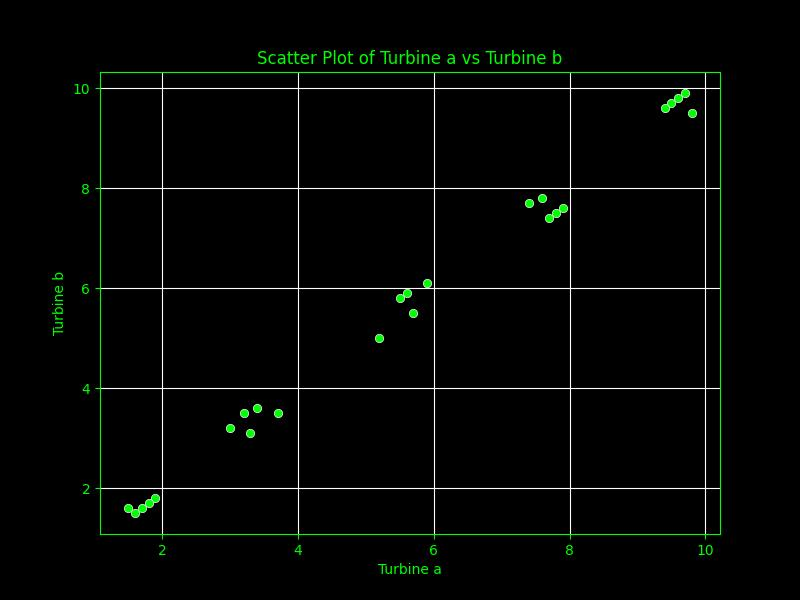

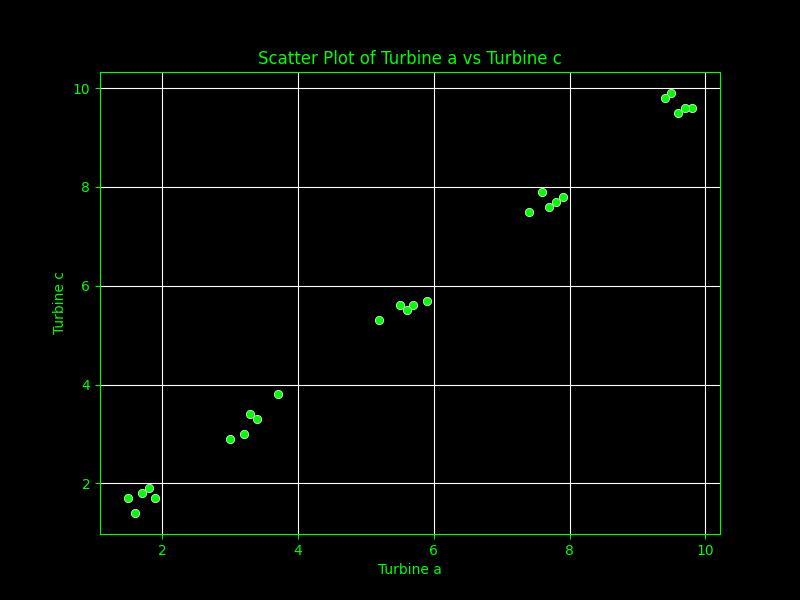

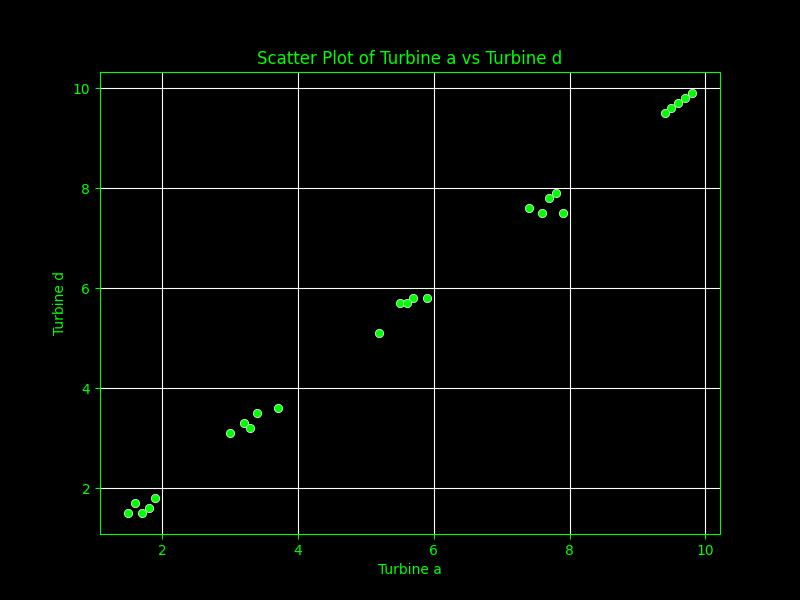

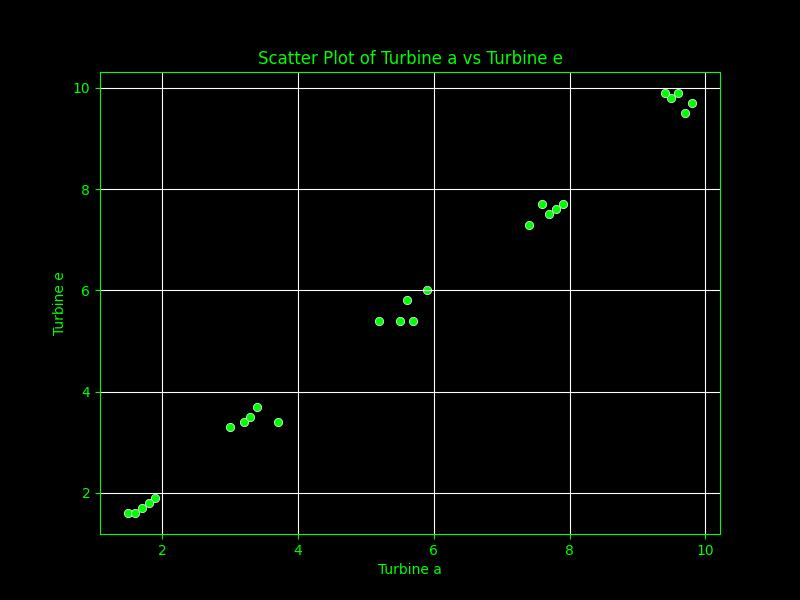

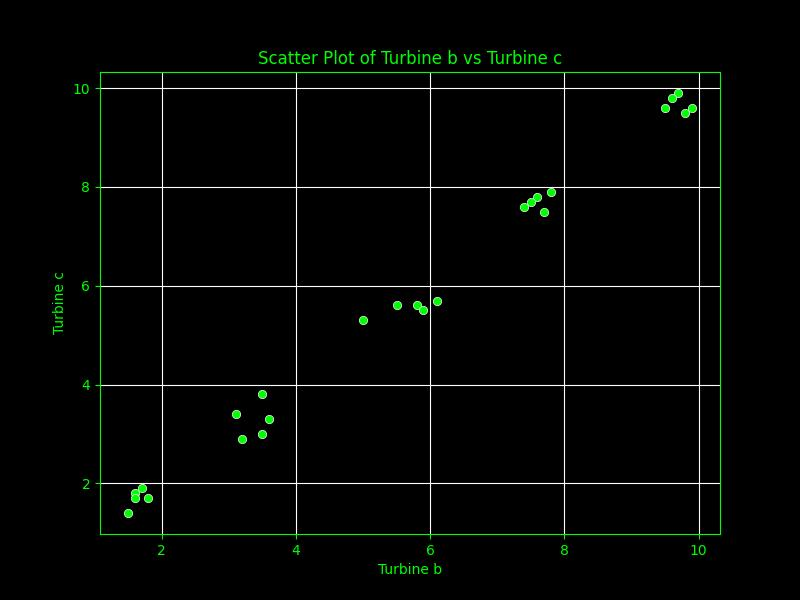

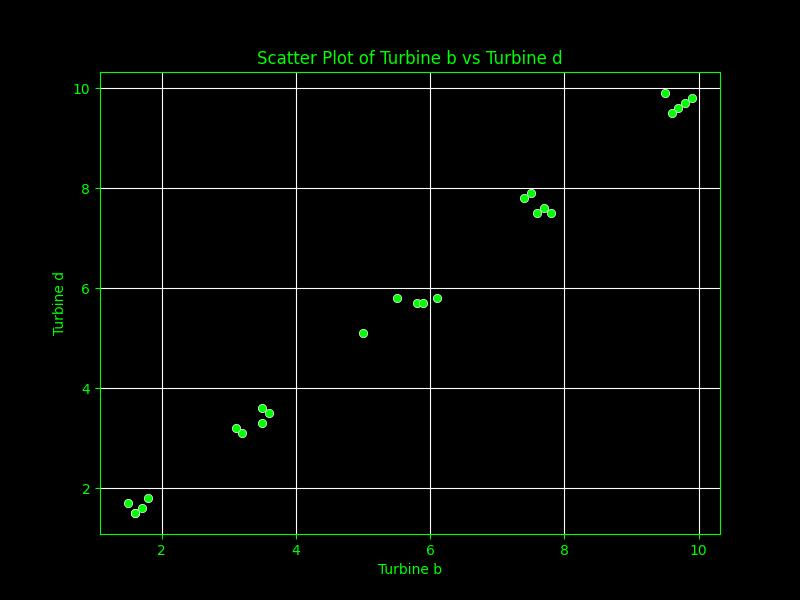

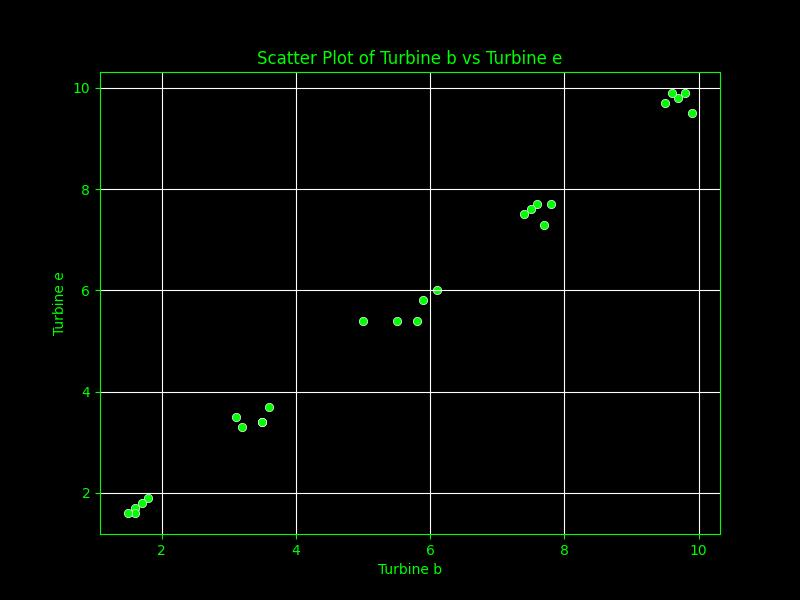

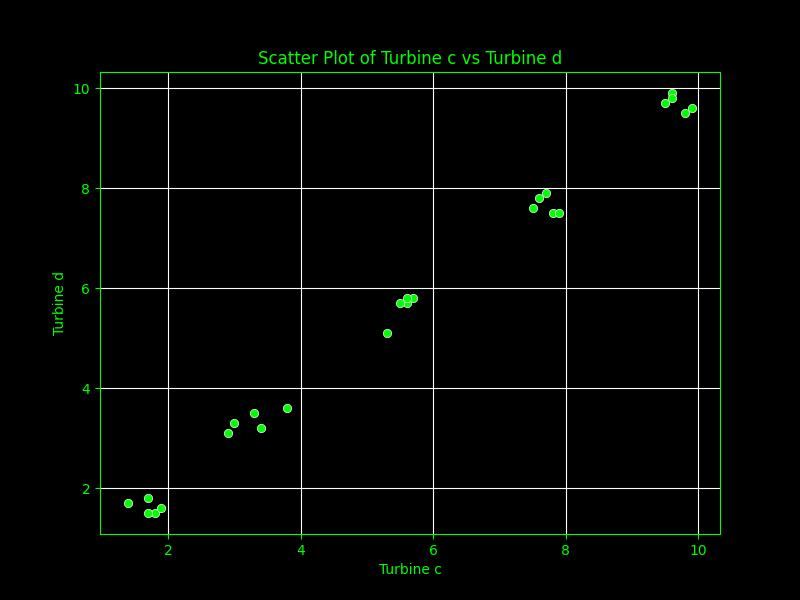

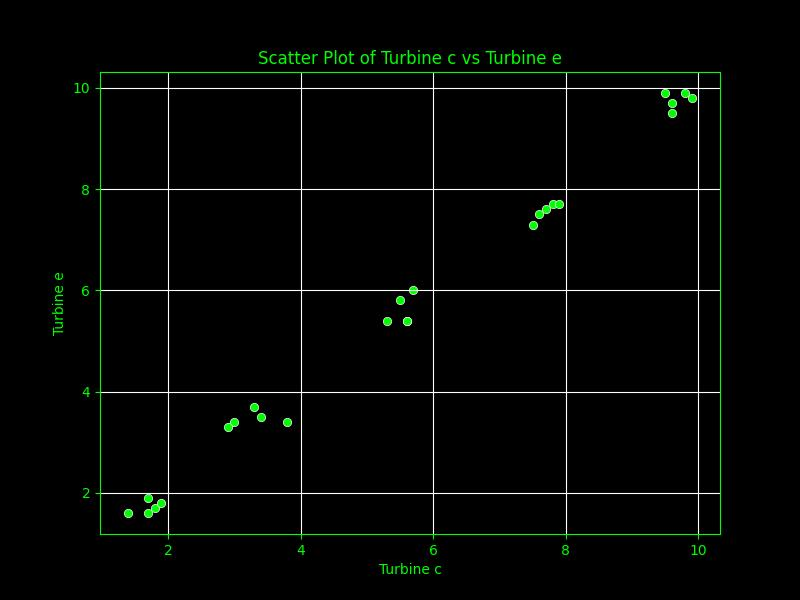

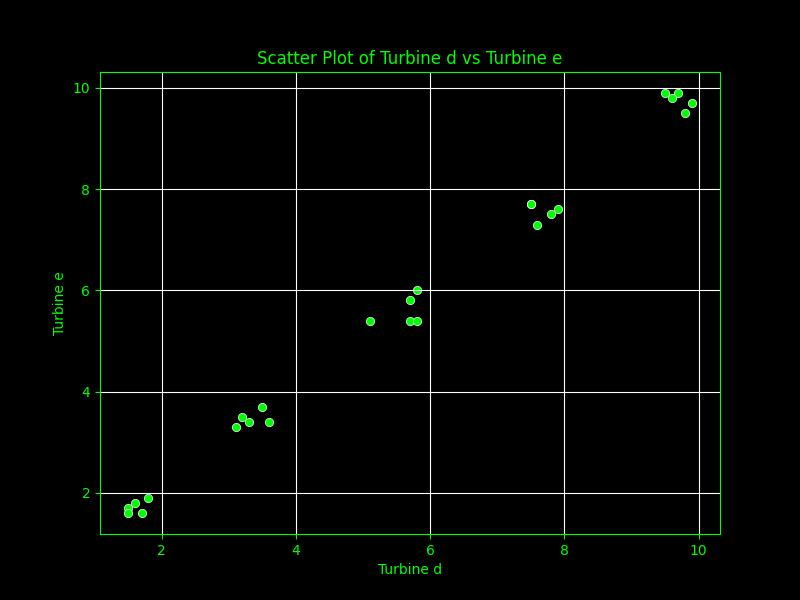

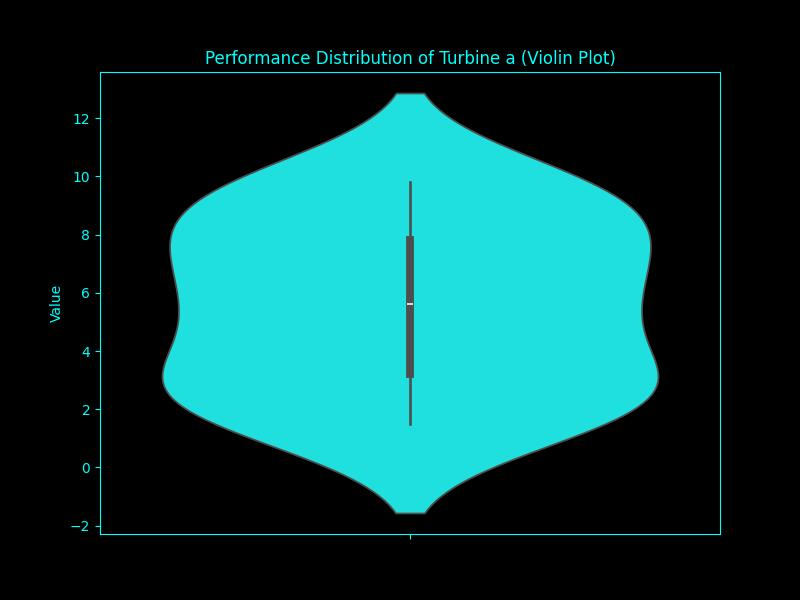

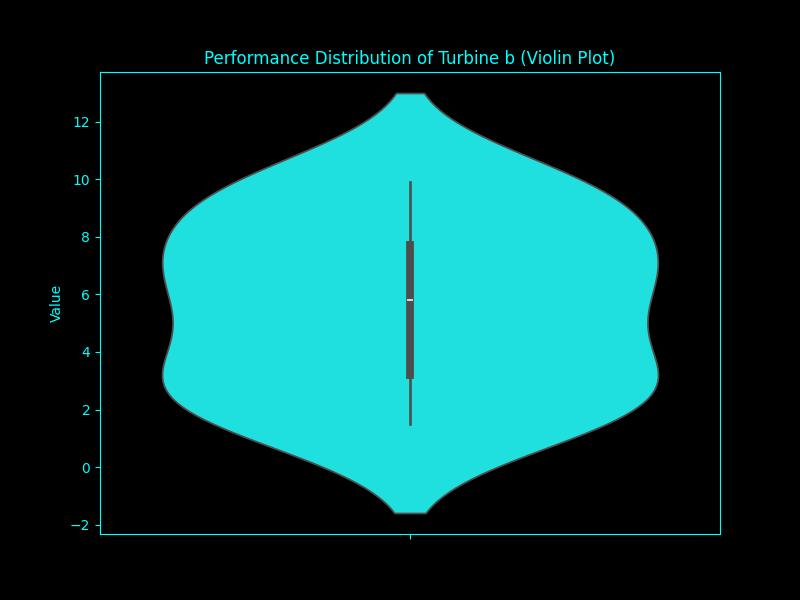

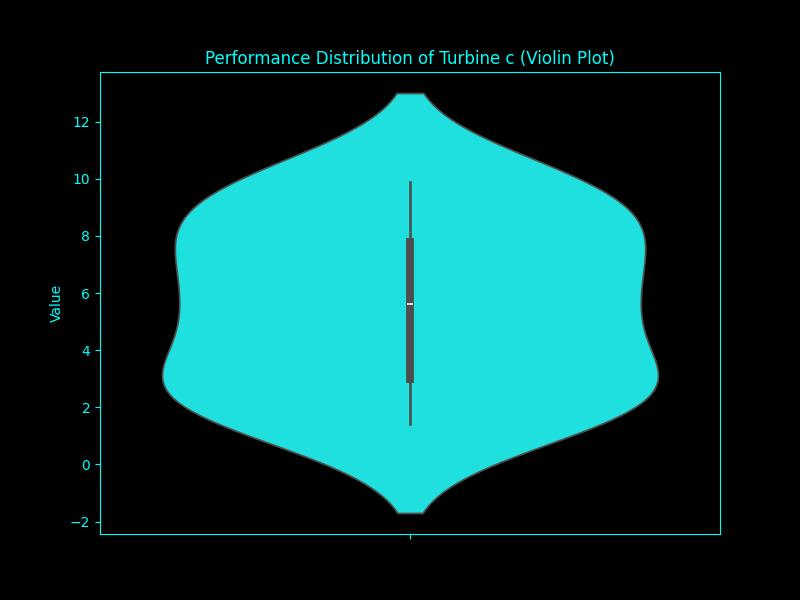

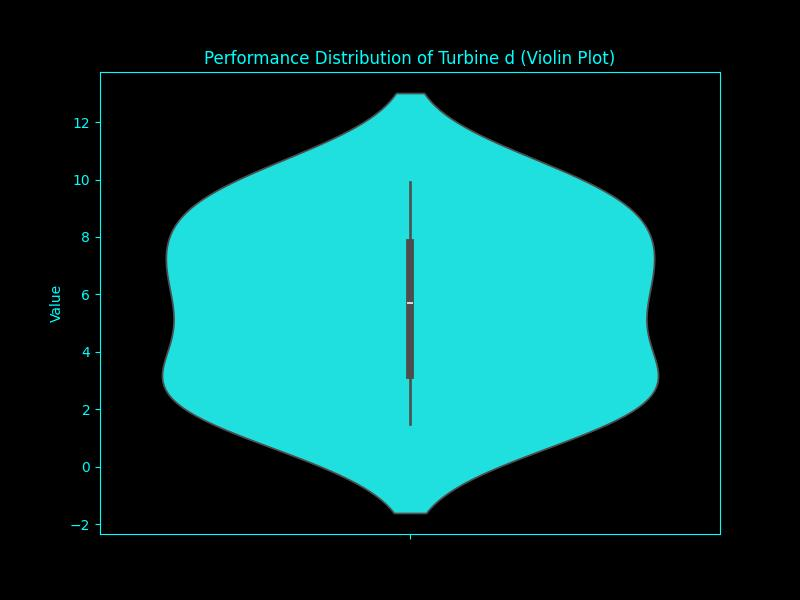

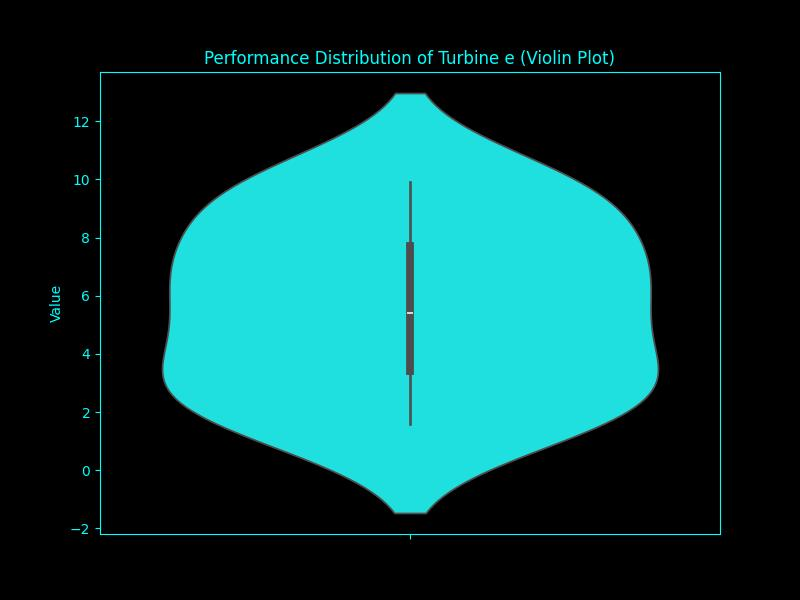

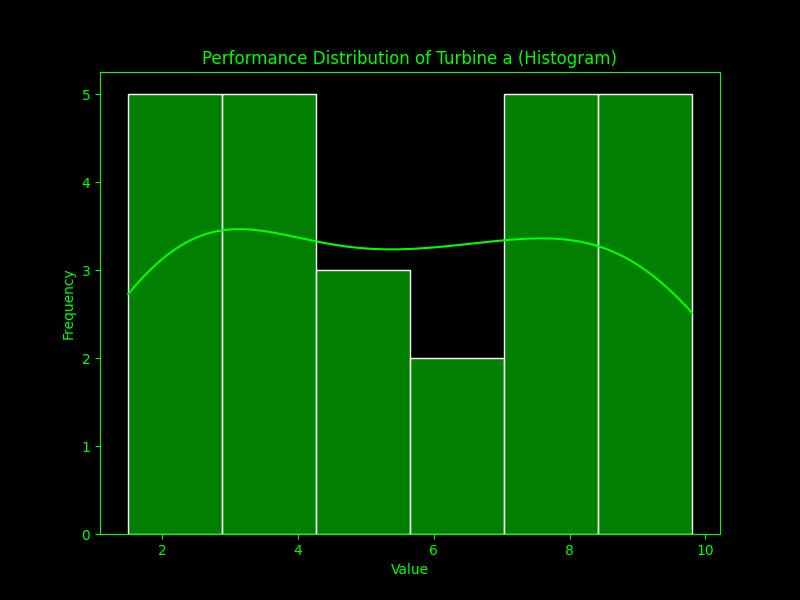

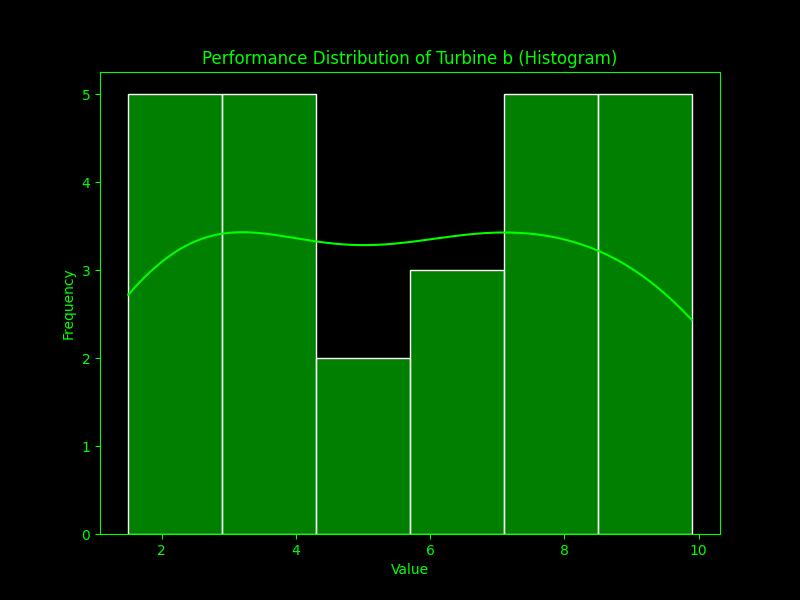

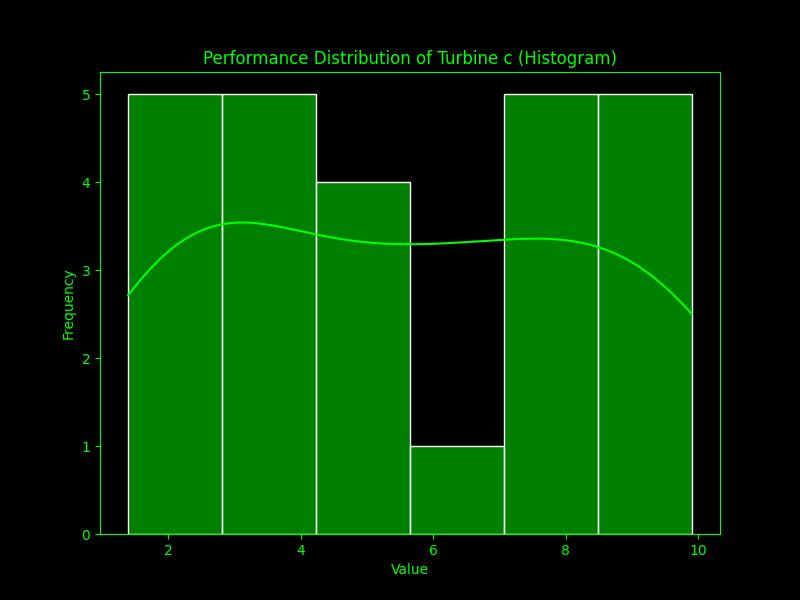

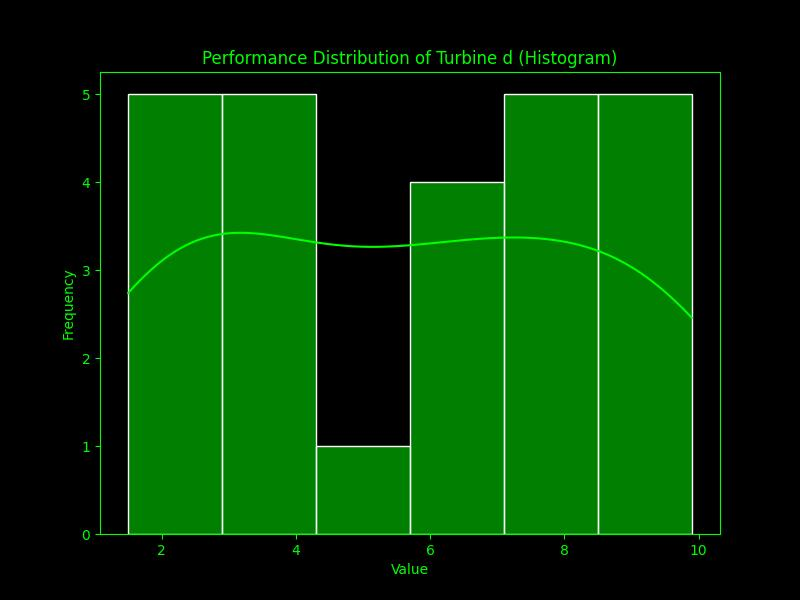

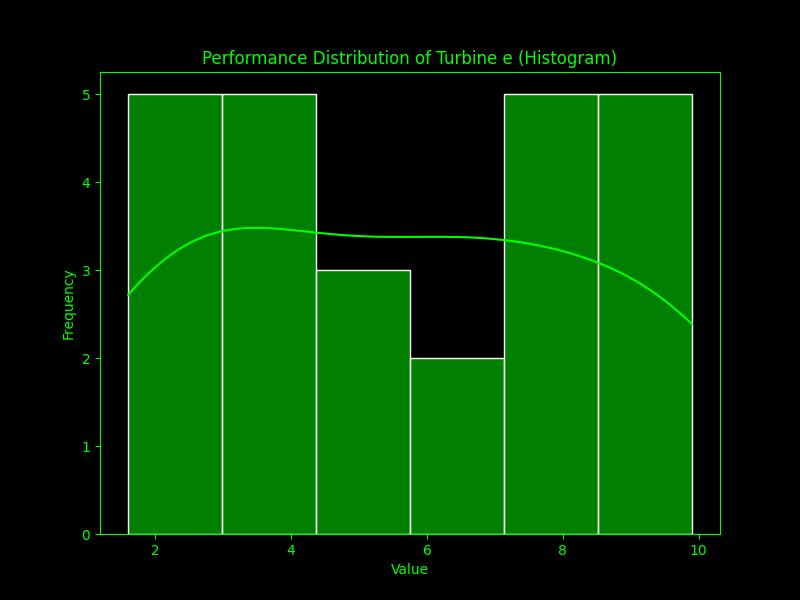

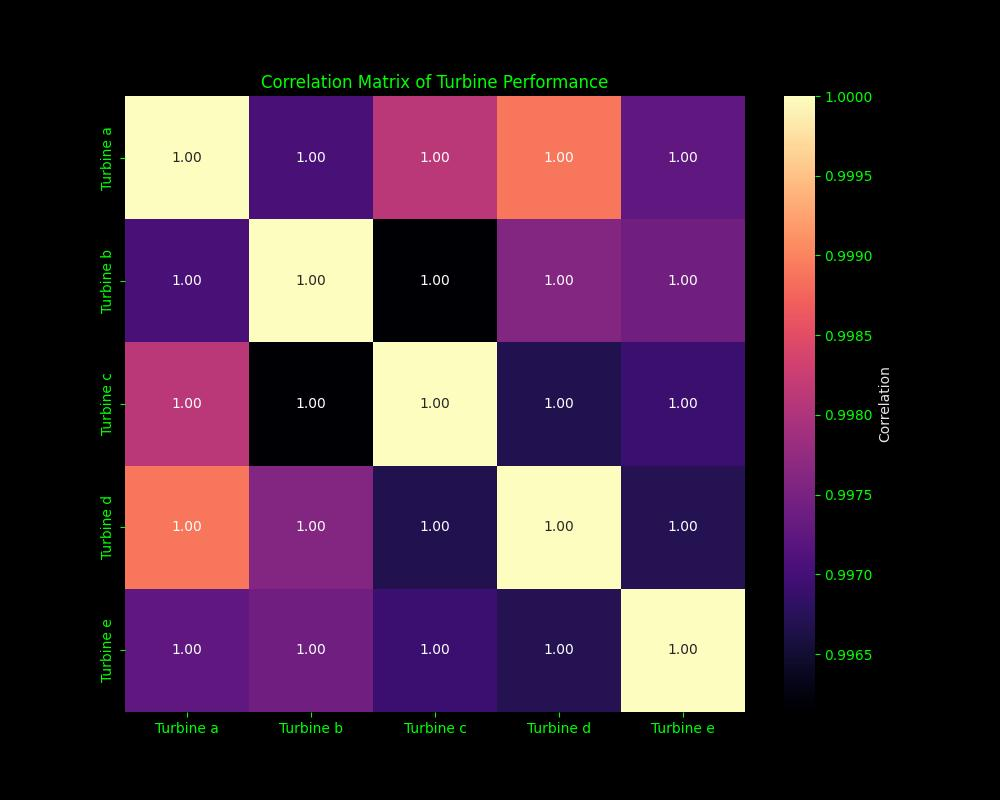

Graphs saved to the '/content/visual' folder.
Turbine Turbine a, Segment 1a: Excitation = 1.7, Adequacy = 0.23
Skipping segment '1b' due to invalid format for conversion to integer.
Skipping segment '1c' due to invalid format for conversion to integer.
Skipping segment '1d' due to invalid format for conversion to integer.
Skipping segment '1e' due to invalid format for conversion to integer.
Turbine Turbine a, Segment 2a: Excitation = 3.2, Adequacy = 0.62
Skipping segment '2b' due to invalid format for conversion to integer.
Skipping segment '2c' due to invalid format for conversion to integer.
Skipping segment '2d' due to invalid format for conversion to integer.
Skipping segment '2e' due to invalid format for conversion to integer.
Turbine Turbine a, Segment 3a: Excitation = 5.5, Adequacy = 0.83
Skipping segment '3b' due to invalid format for conversion to integer.
Skipping segment '3c' due to invalid format for conversion to integer.
Skipping segment '3d' due to invalid format for c

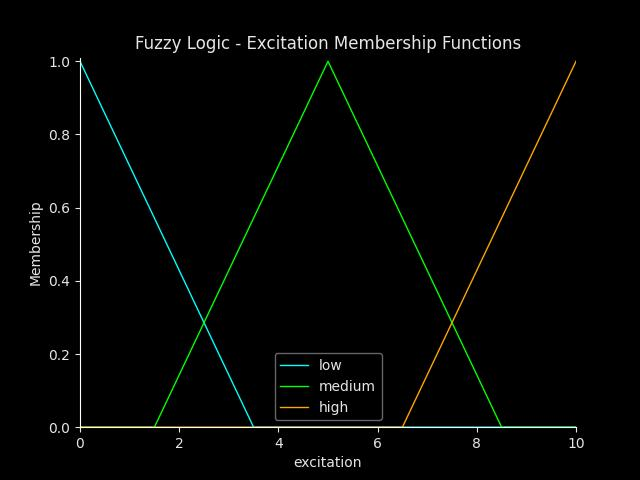

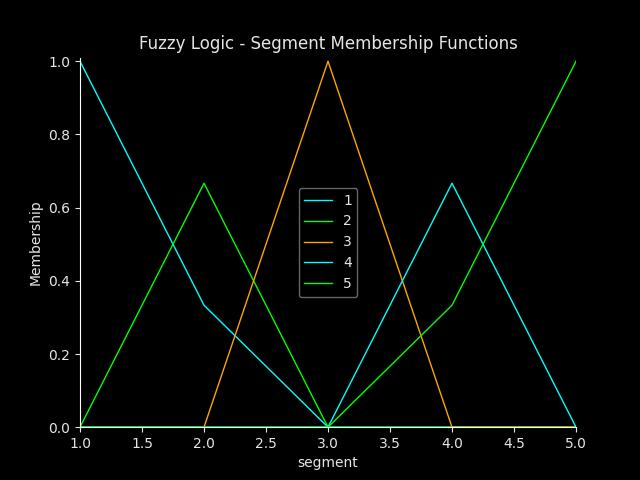

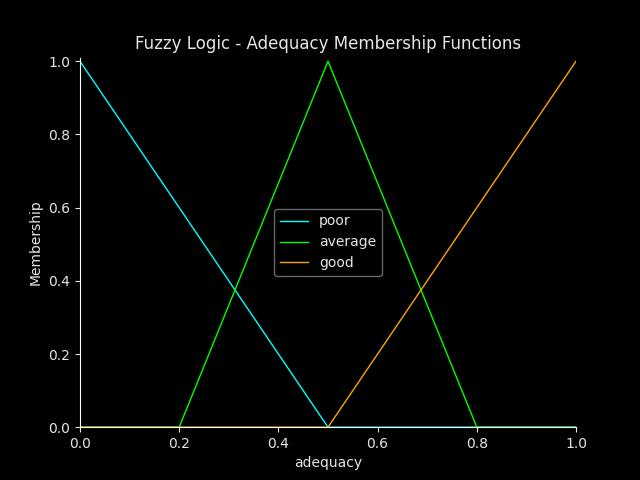

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gspread
from google.colab import auth
import numpy as np
from IPython.display import Image, display
import subprocess

# Install scikit-fuzzy using pip
subprocess.check_call(['pip', 'install', '-U', 'scikit-fuzzy'])
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# --- Configuration ---

# Google Sheets URL
SPREADSHEET_URL = 'https://docs.google.com/spreadsheets/d/146VlNAl8FNm5oC7wgIjbI07PPJ85CZZWecrVA9jDgf0/edit?usp=sharing'

# Output folder for graphs (use a path within your Colab environment)
OUTPUT_FOLDER = '/content/visual'

# --- Helper Functions with Enhanced Error Handling and Input Validation ---

def authenticate_gspread():
    """Authenticates with Google Sheets using Google Colab's built-in auth."""
    try:
        auth.authenticate_user()
        creds, _ = default()
        gc = gspread.authorize(creds)
        return gc
    except Exception as e:
        print(f"Error during Google Sheets authentication: {e}")
        return None

def load_data_from_spreadsheet(gc, url):
    """Loads data from a Google Sheet with error handling."""
    if gc is None:
        print("Google Sheets client is not initialized.")
        return None

    if not isinstance(url, str) or not url:
        print("Invalid Google Sheets URL provided.")
        return None

    try:
        sheet = gc.open_by_url(url)
        worksheet = sheet.sheet1
        data = worksheet.get_all_values()

        if not data:
            print("No data found in the spreadsheet.")
            return None

        df = pd.DataFrame(data[1:], columns=data[0])

        # Validate and convert necessary columns to numeric
        for col in df.columns:
            if col != 'Segment/Turbine':
                try:
                    df[col] = pd.to_numeric(df[col], errors='raise')
                except ValueError:
                    print(f"Non-numeric data found in column '{col}', which is expected to be numeric.")
                    return None

        return df

    except gspread.exceptions.SpreadsheetNotFound:
        print(f"Error: Spreadsheet not found at URL: {url}")
        return None
    except Exception as e:
        print(f"An error occurred while loading data from the spreadsheet: {e}")
        return None

def extract_turbines(data):
    """Extracts turbine names from the DataFrame with validation."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot extract turbine names.")
        return []

    if 'Segment/Turbine' not in data.columns:
        print("'Segment/Turbine' column not found in DataFrame.")
        return []

    return data.columns[1:].tolist()

def calculate_statistics(data, turbines):
    """Calculates average, maximum, and minimum values for the turbines with validation."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot calculate statistics.")
        return None

    if not turbines:
        print("No turbine names provided. Cannot calculate statistics.")
        return data

    try:
        data['Average'] = data[turbines].mean(axis=1)
        data['Max'] = data[turbines].max(axis=1)
        data['Min'] = data[turbines].min(axis=1)
    except KeyError as e:
        print(f"Error: Column not found during statistics calculation: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during statistics calculation: {e}")
        return None

    return data

# --- Top 9 Graphing Functions with Enhanced Aesthetics and Error Handling ---

def save_individual_turbine_boxplots(data, turbines, output_folder):
    """Creates and saves boxplots for each turbine's performance."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create boxplots.")
        return

    if not turbines:
        print("No turbine names provided. Cannot create boxplots.")
        return

    for turbine in turbines:
        if turbine not in data.columns:
            print(f"Turbine '{turbine}' not found in DataFrame. Skipping boxplot.")
            continue

        plt.figure(figsize=(8, 6), facecolor='black')
        try:
            sns.boxplot(y=data[turbine], color='lime')
            plt.title(f'Performance Distribution of {turbine}', color='lime')
            plt.ylabel('Value', color='lime')
            plt.xticks(color='lime')
            plt.yticks(color='lime')
            ax = plt.gca()
            ax.set_facecolor('black')
            ax.spines['bottom'].set_color('lime')
            ax.spines['top'].set_color('lime')
            ax.spines['left'].set_color('lime')
            ax.spines['right'].set_color('lime')
            ax.tick_params(axis='x', colors='lime')
            ax.tick_params(axis='y', colors='lime')
            output_path = os.path.join(output_folder, f'{turbine}_boxplot.jpg')
            plt.savefig(output_path)
            plt.close()
            display(Image(filename=output_path))
        except Exception as e:
            print(f"Error creating boxplot for {turbine}: {e}")
            plt.close()

def save_turbine_vs_average_lineplots(data, turbines, output_folder):
    """Creates and saves line plots comparing each turbine to the average."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create line plots.")
        return

    if not turbines:
        print("No turbine names provided. Cannot create line plots.")
        return

    for turbine in turbines:
        if turbine not in data.columns or 'Average' not in data.columns:
            print(f"Missing columns in DataFrame for line plot ({turbine} or Average). Skipping.")
            continue

        plt.figure(figsize=(8, 6), facecolor='black')
        try:
            sns.lineplot(x='Segment/Turbine', y=turbine, data=data, marker='o', label=turbine, color='cyan')
            sns.lineplot(x='Segment/Turbine', y='Average', data=data, marker='s', linestyle='--', label='Average', color='orange')
            plt.title(f'{turbine} vs Average', color='cyan')
            plt.xlabel('Segment/Turbine', color='cyan')
            plt.ylabel('Value', color='cyan')
            plt.xticks(rotation=45, color='cyan')
            plt.yticks(color='cyan')
            plt.legend()
            plt.grid(True)
            ax = plt.gca()
            ax.set_facecolor('black')
            ax.spines['bottom'].set_color('cyan')
            ax.spines['top'].set_color('cyan')
            ax.spines['left'].set_color('cyan')
            ax.spines['right'].set_color('cyan')
            ax.tick_params(axis='x', colors='cyan')
            ax.tick_params(axis='y', colors='cyan')
            output_path = os.path.join(output_folder, f'{turbine}_vs_average_lineplot.jpg')
            plt.savefig(output_path)
            plt.close()
            display(Image(filename=output_path))
        except Exception as e:
            print(f"Error creating line plot for {turbine}: {e}")
            plt.close()

def save_turbine_vs_min_max_lineplots(data, turbines, output_folder):
    """Creates and saves line plots comparing each turbine to the maximum and minimum values."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create line plots.")
        return

    if not turbines:
        print("No turbine names provided. Cannot create line plots.")
        return

    for turbine in turbines:
        if turbine not in data.columns or 'Max' not in data.columns or 'Min' not in data.columns:
            print(f"Missing columns in DataFrame for line plot ({turbine}, Max, or Min). Skipping.")
            continue

        plt.figure(figsize=(8, 6), facecolor='black')
        try:
            sns.lineplot(x='Segment/Turbine', y=turbine, data=data, marker='o', label=turbine, color='magenta')
            sns.lineplot(x='Segment/Turbine', y='Max', data=data, marker='^', linestyle='--', label='Max', color='lime')
            sns.lineplot(x='Segment/Turbine', y='Min', data=data, marker='v', linestyle='--', label='Min', color='yellow')
            plt.title(f'{turbine} vs Max and Min', color='magenta')
            plt.xlabel('Segment/Turbine', color='magenta')
            plt.ylabel('Value', color='magenta')
            plt.xticks(rotation=45, color='magenta')
            plt.yticks(color='magenta')
            plt.legend()
            plt.grid(True)
            ax = plt.gca()
            ax.set_facecolor('black')
            ax.spines['bottom'].set_color('magenta')
            ax.spines['top'].set_color('magenta')
            ax.spines['left'].set_color('magenta')
            ax.spines['right'].set_color('magenta')
            ax.tick_params(axis='x', colors='magenta')
            ax.tick_params(axis='y', colors='magenta')
            output_path = os.path.join(output_folder, f'{turbine}_vs_min_max_lineplot.jpg')
            plt.savefig(output_path)
            plt.close()
            display(Image(filename=output_path))
        except Exception as e:
            print(f"Error creating line plot for {turbine}: {e}")
            plt.close()

def save_comparison_heatmap(data, turbines, output_folder):
    """Creates and saves a heatmap for all turbines."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create heatmap.")
        return

    if not turbines:
        print("No turbine names provided. Cannot create heatmap.")
        return

    plt.figure(figsize=(10, 8), facecolor='black')
    try:
        sns.heatmap(data[turbines].transpose(), cmap='magma', annot=True, fmt=".1f", cbar_kws={'label': 'Value'})
        plt.title('Heatmap of Turbine Performance', color='orange')
        plt.xlabel('Segment/Turbine', color='orange')
        plt.ylabel('Turbine', color='orange')
        plt.xticks(color='orange')
        plt.yticks(color='orange')
        ax = plt.gca()
        ax.set_facecolor('black')
        ax.spines['bottom'].set_color('orange')
        ax.spines['top'].set_color('orange')
        ax.spines['left'].set_color('orange')
        ax.spines['right'].set_color('orange')
        ax.tick_params(axis='x', colors='orange')
        ax.tick_params(axis='y', colors='orange')
        cbar = ax.collections[0].colorbar
        cbar.ax.yaxis.set_tick_params(color='orange')
        cbar.outline.set_edgecolor('orange')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='orange')
        output_path = os.path.join(output_folder, 'all_turbines_heatmap.jpg')
        plt.savefig(output_path)
        plt.close()
        display(Image(filename=output_path))
    except Exception as e:
        print(f"Error creating heatmap: {e}")
        plt.close()

def save_average_vs_min_max_barplot(data, output_folder):
    """Creates and saves a bar plot comparing the average to the maximum and minimum values."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create bar plot.")
        return

    if 'Average' not in data.columns or 'Max' not in data.columns or 'Min' not in data.columns:
        print("Missing columns in DataFrame for bar plot (Average, Max, or Min). Skipping.")
        return

    plt.figure(figsize=(8, 6), facecolor='black')
    try:
        data[['Average', 'Max', 'Min']].plot(kind='bar', ax=plt.gca(), color=['cyan', 'lime', 'magenta'])
        plt.title('Average vs Max and Min', color='cyan')
        plt.xlabel('Segment/Turbine', color='cyan')
        plt.ylabel('Value', color='cyan')
        plt.xticks(rotation=45, color='cyan')
        plt.yticks(color='cyan')
        plt.grid(True)
        ax = plt.gca()
        ax.set_facecolor('black')
        ax.spines['bottom'].set_color('cyan')
        ax.spines['top'].set_color('cyan')
        ax.spines['left'].set_color('cyan')
        ax.spines['right'].set_color('cyan')
        ax.tick_params(axis='x', colors='cyan')
        ax.tick_params(axis='y', colors='cyan')
        output_path = os.path.join(output_folder, 'average_vs_min_max_barplot.jpg')
        plt.savefig(output_path)
        plt.close()
        display(Image(filename=output_path))
    except Exception as e:
        print(f"Error creating bar plot: {e}")
        plt.close()

def save_pairwise_turbine_scatterplots(data, turbines, output_folder):
    """Creates and saves scatter plots comparing turbines in pairs."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create scatter plots.")
        return

    if not turbines:
        print("No turbine names provided. Cannot create scatter plots.")
        return

    num_turbines = len(turbines)
    for i in range(num_turbines):
        for j in range(i + 1, num_turbines):
            turbine1 = turbines[i]
            turbine2 = turbines[j]

            if turbine1 not in data.columns or turbine2 not in data.columns:
                print(f"Turbines {turbine1} or {turbine2} not found in DataFrame. Skipping scatter plot.")
                continue

            plt.figure(figsize=(8, 6), facecolor='black')
            try:
                sns.scatterplot(x=turbine1, y=turbine2, data=data, color='lime')
                plt.title(f'Scatter Plot of {turbine1} vs {turbine2}', color='lime')
                plt.xlabel(turbine1, color='lime')
                plt.ylabel(turbine2, color='lime')
                plt.xticks(color='lime')
                plt.yticks(color='lime')
                plt.grid(True)
                ax = plt.gca()
                ax.set_facecolor('black')
                ax.spines['bottom'].set_color('lime')
                ax.spines['top'].set_color('lime')
                ax.spines['left'].set_color('lime')
                ax.spines['right'].set_color('lime')
                ax.tick_params(axis='x', colors='lime')
                ax.tick_params(axis='y', colors='lime')
                output_path = os.path.join(output_folder, f'{turbine1}_vs_{turbine2}_scatterplot.jpg')
                plt.savefig(output_path)
                plt.close()
                display(Image(filename=output_path))
            except Exception as e:
                print(f"Error creating scatter plot for {turbine1} vs {turbine2}: {e}")
                plt.close()

def save_violin_plots(data, turbines, output_folder):
    """Creates and saves violin plots for each turbine's performance."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create violin plots.")
        return

    if not turbines:
        print("No turbine names provided. Cannot create violin plots.")
        return

    for turbine in turbines:
        if turbine not in data.columns:
            print(f"Turbine '{turbine}' not found in DataFrame. Skipping violin plot.")
            continue

        plt.figure(figsize=(8, 6), facecolor='black')
        try:
            sns.violinplot(y=data[turbine], color='cyan')
            plt.title(f'Performance Distribution of {turbine} (Violin Plot)', color='cyan')
            plt.ylabel('Value', color='cyan')
            plt.xticks(color='cyan')
            plt.yticks(color='cyan')
            ax = plt.gca()
            ax.set_facecolor('black')
            ax.spines['bottom'].set_color('cyan')
            ax.spines['top'].set_color('cyan')
            ax.spines['left'].set_color('cyan')
            ax.spines['right'].set_color('cyan')
            ax.tick_params(axis='x', colors='cyan')
            ax.tick_params(axis='y', colors='cyan')
            output_path = os.path.join(output_folder, f'{turbine}_violinplot.jpg')
            plt.savefig(output_path)
            plt.close()
            display(Image(filename=output_path))
        except Exception as e:
            print(f"Error creating violin plot for {turbine}: {e}")
            plt.close()

def save_histogram(data, turbines, output_folder):
    """Creates and saves histograms for each turbine's performance."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create histograms.")
        return

    if not turbines:
        print("No turbine names provided. Cannot create histograms.")
        return

    for turbine in turbines:
        if turbine not in data.columns:
            print(f"Turbine '{turbine}' not found in DataFrame. Skipping histogram.")
            continue

        plt.figure(figsize=(8, 6), facecolor='black')
        try:
            sns.histplot(data[turbine], kde=True, color='lime')
            plt.title(f'Performance Distribution of {turbine} (Histogram)', color='lime')
            plt.xlabel('Value', color='lime')
            plt.ylabel('Frequency', color='lime')
            plt.xticks(color='lime')
            plt.yticks(color='lime')
            ax = plt.gca()
            ax.set_facecolor('black')
            ax.spines['bottom'].set_color('lime')
            ax.spines['top'].set_color('lime')
            ax.spines['left'].set_color('lime')
            ax.spines['right'].set_color('lime')
            ax.tick_params(axis='x', colors='lime')
            ax.tick_params(axis='y', colors='lime')
            output_path = os.path.join(output_folder, f'{turbine}_histogram.jpg')
            plt.savefig(output_path)
            plt.close()
            display(Image(filename=output_path))
        except Exception as e:
            print(f"Error creating histogram for {turbine}: {e}")
            plt.close()

def save_correlation_matrix_heatmap(data, turbines, output_folder):
    """Creates and saves a heatmap of the correlation matrix for all turbines."""
    if data is None or data.empty:
        print("DataFrame is None or empty. Cannot create correlation matrix heatmap.")
        return

    if not turbines:
        print("No turbine names provided. Cannot create correlation matrix heatmap.")
        return

    plt.figure(figsize=(10, 8), facecolor='black')
    try:
        correlation_matrix = data[turbines].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt=".2f", cbar_kws={'label': 'Correlation'})
        plt.title('Correlation Matrix of Turbine Performance', color='lime')
        plt.xticks(color='lime')
        plt.yticks(color='lime')
        ax = plt.gca()
        ax.set_facecolor('black')
        ax.spines['bottom'].set_color('lime')
        ax.spines['top'].set_color('lime')
        ax.spines['left'].set_color('lime')
        ax.spines['right'].set_color('lime')
        ax.tick_params(axis='x', colors='lime')
        ax.tick_params(axis='y', colors='lime')
        cbar = ax.collections[0].colorbar
        cbar.ax.yaxis.set_tick_params(color='lime')
        cbar.outline.set_edgecolor('lime')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='lime')
        output_path = os.path.join(output_folder, 'correlation_matrix_heatmap.jpg')
        plt.savefig(output_path)
        plt.close()
        display(Image(filename=output_path))
    except Exception as e:
        print(f"Error creating correlation matrix heatmap: {e}")
        plt.close()

# --- Fuzzy Logic Functions ---

def setup_fuzzy_logic():
    """Sets up the fuzzy logic system (antecedents, consequents, membership functions, and rules)."""
    # Antecedent objects (Inputs)
    excitation = ctrl.Antecedent(np.arange(0, 10.1, 0.1), 'excitation')
    segment = ctrl.Antecedent(np.arange(1, 6, 1), 'segment')

    # Consequent object (Output)
    adequacy = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'adequacy')

    # Membership functions for excitation
    excitation['low'] = fuzz.trimf(excitation.universe, [0, 0, 3.5])
    excitation['medium'] = fuzz.trimf(excitation.universe, [1.5, 5, 8.5])
    excitation['high'] = fuzz.trimf(excitation.universe, [6.5, 10, 10])

    # Membership functions for segment
    segment['1'] = fuzz.trimf(segment.universe, [1, 1, 2.5])
    segment['2'] = fuzz.trimf(segment.universe, [1, 2.5, 3])
    segment['3'] = fuzz.trimf(segment.universe, [2.5, 3, 3.5])
    segment['4'] = fuzz.trimf(segment.universe, [3, 3.5, 5])
    segment['5'] = fuzz.trimf(segment.universe, [3.5, 5, 5])

    # Membership functions for adequacy
    adequacy['poor'] = fuzz.trimf(adequacy.universe, [0, 0, 0.5])
    adequacy['average'] = fuzz.trimf(adequacy.universe, [0.2, 0.5, 0.8])
    adequacy['good'] = fuzz.trimf(adequacy.universe, [0.5, 1, 1])

    # Fuzzy rules
    rules = [
        ctrl.Rule(excitation['low'] & segment['1'], adequacy['poor']),
        ctrl.Rule(excitation['low'] & segment['2'], adequacy['poor']),
        ctrl.Rule(excitation['low'] & segment['3'], adequacy['poor']),
        ctrl.Rule(excitation['low'] & segment['4'], adequacy['average']),
        ctrl.Rule(excitation['low'] & segment['5'], adequacy['average']),
        ctrl.Rule(excitation['medium'] & segment['1'], adequacy['average']),
        ctrl.Rule(excitation['medium'] & segment['2'], adequacy['good']),
        ctrl.Rule(excitation['medium'] & segment['3'], adequacy['good']),
        ctrl.Rule(excitation['medium'] & segment['4'], adequacy['good']),
        ctrl.Rule(excitation['medium'] & segment['5'], adequacy['average']),
        ctrl.Rule(excitation['high'] & segment['1'], adequacy['average']),
        ctrl.Rule(excitation['high'] & segment['2'], adequacy['average']),
        ctrl.Rule(excitation['high'] & segment['3'], adequacy['good']),
        ctrl.Rule(excitation['high'] & segment['4'], adequacy['good']),
        ctrl.Rule(excitation['high'] & segment['5'], adequacy['poor']),
    ]

    return ctrl.ControlSystem(rules)

def evaluate_fuzzy_logic(control_system, df, turbines, segments):
    """Evaluates the fuzzy logic system for each turbine and segment."""
    control_system_simulation = ctrl.ControlSystemSimulation(control_system)
    results = {}

    for turbine in turbines:
        for segment_label in segments:
            try:
                segment_val = int(segment_label.split('a')[0]) # Extract numeric part of segment label
                data_slice = df.loc[df['Segment/Turbine'] == segment_label, turbine]

                if not data_slice.empty:
                    excitation = data_slice.iloc[0]
                    try:
                        control_system_simulation.input['excitation'] = excitation
                        control_system_simulation.input['segment'] = segment_val
                        control_system_simulation.compute()
                        adequacy_value = control_system_simulation.output['adequacy']
                        results[(turbine, segment_val)] = adequacy_value
                        print(f"Turbine {turbine}, Segment {segment_label}: Excitation = {excitation}, Adequacy = {adequacy_value:.2f}")
                    except Exception as e:
                        print(f"Error processing Turbine {turbine}, Segment {segment_label}: {e}")
                else:
                    print(f"Could not find data for Turbine {turbine}, Segment {segment_label} in the spreadsheet.")
            except ValueError:
                print(f"Skipping segment '{segment_label}' due to invalid format for conversion to integer.")

    return results

def generate_fuzzy_plots(fuzzy_results, output_folder):
    """Generates and saves fuzzy logic related plots."""
    fuzzy_path = os.path.join(output_folder, 'fuzzy')
    if not os.path.exists(fuzzy_path):
        os.makedirs(fuzzy_path)

    # Graph 17: Membership functions for excitation
    excitation = ctrl.Antecedent(np.arange(0, 10.1, 0.1), 'excitation')
    excitation['low'] = fuzz.trimf(excitation.universe, [0, 0, 3.5])
    excitation['medium'] = fuzz.trimf(excitation.universe, [1.5, 5, 8.5])
    excitation['high'] = fuzz.trimf(excitation.universe, [6.5, 10, 10])
    plt.figure(figsize=(10, 5))
    excitation.view()
    plt.title('Fuzzy Logic - Excitation Membership Functions')
    plt.savefig(f'{fuzzy_path}/fuzzy_excitation_membership.jpg')
    plt.close()
    display(Image(filename=f'{fuzzy_path}/fuzzy_excitation_membership.jpg'))

    # Graph 18: Membership functions for segment
    segment = ctrl.Antecedent(np.arange(1, 6, 1), 'segment')
    segment['1'] = fuzz.trimf(segment.universe, [1, 1, 2.5])
    segment['2'] = fuzz.trimf(segment.universe, [1, 2.5, 3])
    segment['3'] = fuzz.trimf(segment.universe, [2.5, 3, 3.5])
    segment['4'] = fuzz.trimf(segment.universe, [3, 3.5, 5])
    segment['5'] = fuzz.trimf(segment.universe, [3.5, 5, 5])
    plt.figure(figsize=(10, 5))
    segment.view()
    plt.title('Fuzzy Logic - Segment Membership Functions')
    plt.savefig(f'{fuzzy_path}/fuzzy_segment_membership.jpg')
    plt.close()
    display(Image(filename=f'{fuzzy_path}/fuzzy_segment_membership.jpg'))

    # Graph 19: Membership functions for adequacy
    adequacy = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'adequacy')
    adequacy['poor'] = fuzz.trimf(adequacy.universe, [0, 0, 0.5])
    adequacy['average'] = fuzz.trimf(adequacy.universe, [0.2, 0.5, 0.8])
    adequacy['good'] = fuzz.trimf(adequacy.universe, [0.5, 1, 1])
    plt.figure(figsize=(10, 5))
    adequacy.view()
    plt.title('Fuzzy Logic - Adequacy Membership Functions')
    plt.savefig(f'{fuzzy_path}/fuzzy_adequacy_membership.jpg')
    plt.close()
    display(Image(filename=f'{fuzzy_path}/fuzzy_adequacy_membership.jpg'))

# --- Main Execution ---

# Ensure the output folder exists
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Step 1: Authenticate with Google Sheets
gc = authenticate_gspread()

# Step 2: Load data from the spreadsheet
data = load_data_from_spreadsheet(gc, SPREADSHEET_URL)
turbines = []
segments = []

if data is not None:
    turbines = extract_turbines(data)
    unique_segments = set()
    for item in data['Segment/Turbine']:
        try:
            unique_segments.add(item)
        except:
            pass
    segments = sorted(list(unique_segments))

# Step 3: Calculate statistics
data = calculate_statistics(data, turbines)

# Step 4: Generate and save the top 9 types of graphs
if data is not None and turbines:
    # Set the style for all plots
    plt.style.use('dark_background')
    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0.9'  # Very light grey
    for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
        plt.rcParams[param] = '#000000'  # Set background color to black
    colors = ['#00FFFF', '#00FF00', '#FFA500']  # Neon cyan, green, and orange
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

    save_individual_turbine_boxplots(data, turbines, OUTPUT_FOLDER)
    save_turbine_vs_average_lineplots(data, turbines, OUTPUT_FOLDER)
    save_turbine_vs_min_max_lineplots(data, turbines, OUTPUT_FOLDER)
    save_comparison_heatmap(data, turbines, OUTPUT_FOLDER)
    save_average_vs_min_max_barplot(data, OUTPUT_FOLDER)
    save_pairwise_turbine_scatterplots(data, turbines, OUTPUT_FOLDER)
    save_violin_plots(data, turbines, OUTPUT_FOLDER)
    save_histogram(data, turbines, OUTPUT_FOLDER)
    save_correlation_matrix_heatmap(data, turbines, OUTPUT_FOLDER)

    print(f"Graphs saved to the '{OUTPUT_FOLDER}' folder.")

    # Step 5: Setup fuzzy logic system
    control_system = setup_fuzzy_logic()

    # Step 6: Evaluate fuzzy logic system
    if segments:
        fuzzy_results = evaluate_fuzzy_logic(control_system, data, turbines, segments)

        # Step 7: Generate fuzzy logic plots
        generate_fuzzy_plots(fuzzy_results, OUTPUT_FOLDER)
    else:
        print("Could not evaluate fuzzy logic due to segment extraction error.")

else:
    print("Could not generate graphs or perform fuzzy logic analysis due to data loading error.")